## Calculateクラス
### LoadData(): データを読みこむメソッド
- @param pop: 人口メッシュデータ（中心緯度経度、人口データを持つgeojson形式のデータ）
- @param com: 商業集積地区データ（中心緯度経度、売り場面積、売上高を持つgeojson形式のデータ）
            
### Dist(): ヒュべニの公式を用いた二点の距離を求めるメソッド
- @param p1: 緯度経度をリストで持つ地点
- @param p2: 緯度経度をリストで持つ地点

### oneAttract(): 顧客が店舗に行く確率を求めるメソッド
- @apram distList: すべての店舗までの距離のリスト
- @param areaList: すべての店舗の売場面積のリスト
- @param area: 面積補正係数
- @param dist: 距離補正係数
- @return 店舗の魅力度のリスト

### CleanList(): リストの-9999を0に変換するメソッド
- @param ln: 変換するリスト
- @return 変換後のリスト

### PredictSale(): 売上高を求めるメソッド
- @param pop_ptList 人口メッシュの緯度経度リスト
- @param pop_popList 人口メッシュの人口リスト
- @param com_ptList 商業施設の緯度経度リスト
- @param com_areaList 商業施設の売り場面積リスト
- @param area,dist 面積補正係数,距離補正係数
- @return predictSale 売上の予測値

## ライブラリ

In [1]:
import numpy as np
import json
import tqdm
from huffcalculate import Calculate
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Calculateクラスのコンストラクタ

In [2]:
calculate = Calculate('100_pop.geojson', 'A_com.geojson')
(pop, com) = calculate.LoadData()

## GeoJSON形式を読み込む

In [63]:
#100mメッシュの点を取得
pop_ptList = [i['geometry']['coordinates'] for i in pop['features']]
#商業施設座標の取得
com_ptList = [i['geometry']['coordinates'] for i in com['features']]

# 商業集積地区の名称を取得
com_name = [i['properties']['field_7'] for i in com['features']]

#売場面積の取得
com_areaList = [i['properties']['売場面積'] for i in com['features']]
com_areaList = [n.replace('X', '0') for n in com_areaList]
com_areaList = np.array([float(n.replace(',', '')) for n in com_areaList])
#100mメッシュの人口を取得, -9999を0に変換
pop_popList = [i['properties']['H27総人口'] for i in pop['features']]
pop_popList = calculate.CleanList(pop_popList)

#売り上げを取得
com_saleList = [i['properties']['年間商品販売額'] for i in com['features']]
#秘匿をゼロに
com_saleList = [n.replace('X', '0') for n in com_saleList]
com_saleList = np.array([float(n.replace(',', '')) for n in com_saleList])

#出力用に取得
#meshcodeの取得
pop_meshcodeList = [i['properties']['MESHCODE'] for i in pop['features']]
#keycodeの取得
pop_keycodeList = [i['properties']['KEYCODE'] for i in pop['features']]

#idを作成
id = np.arange(len(com_areaList))

# 基本プロット

(array([216.,   9.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([     0.,  14452.,  28904.,  43356.,  57808.,  72260.,  86712.,
        101164., 115616., 130068., 144520.]),
 <a list of 10 Patch objects>)

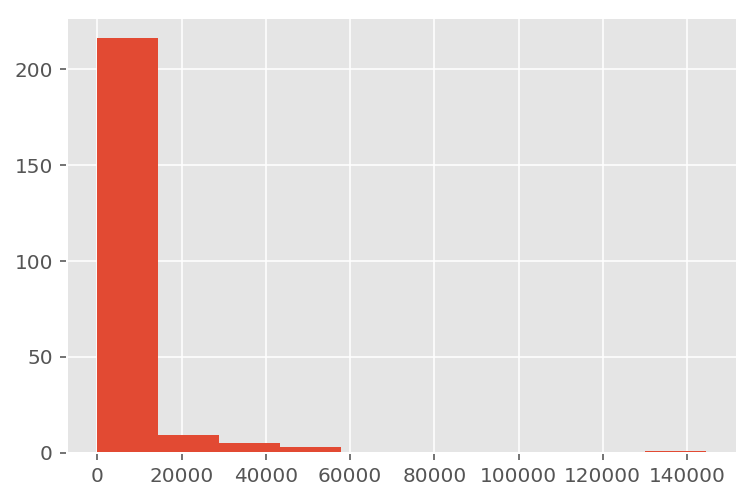

In [41]:
# 売場面積のプロット
plt.hist(com_areaList)

(array([227.,   4.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([     0. ,  27018.6,  54037.2,  81055.8, 108074.4, 135093. ,
        162111.6, 189130.2, 216148.8, 243167.4, 270186. ]),
 <a list of 10 Patch objects>)

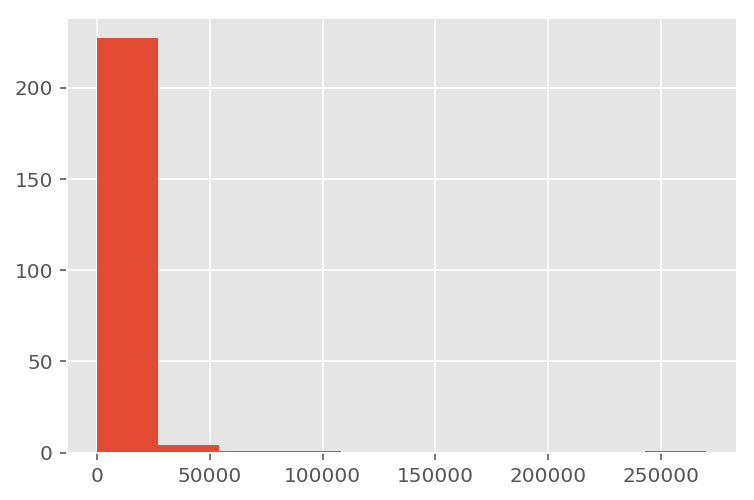

In [43]:
# 元の売り上げのプロット
plt.hist(com_saleList)

## 比例定数の算出
- 売上高/人口 = k(円/人)

In [4]:
popSum = np.sum(pop_popList)
saleSum = np.sum(com_saleList)
k = saleSum / popSum
k

0.5157552019268294

## 係数の定義
- @param area: 面積のべき数
- @param dist: 距離のべき数

In [20]:
area = 1.05
dist = 0.62

## 売上高の予測

In [21]:
predictList = calculate.PredictSale(pop_ptList, pop_popList, com_ptList, com_areaList, area, dist, 400)

100%|██████████| 32564/32564 [02:17<00:00, 236.72it/s]


## 残差の計算

In [23]:
e = com_saleList - k*predictList

## 平均二乗誤差

In [24]:
RMSE = np.sqrt(np.sum(e**2)/len(com_saleList))
RMSE

7773.061925637579

In [47]:
RMSE/y

/Users/kanelab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([7.90748924e+00, 1.34018309e+02, 2.57386156e+01, 1.46330232e+00,
       5.33497730e+00, 8.74360172e+00, 1.65033162e+01, 5.89314778e+00,
       5.25206887e+01, 2.00958168e+00, 1.41328399e+02, 2.94657389e+00,
       2.46771705e-01, 8.09693951e+00, 1.21454093e+02, 8.03002265e+00,
       6.42986345e-01, 7.76840089e-01, 2.01374661e+01, 1.34715111e+01,
       3.71916839e+01, 4.24757482e+00, 9.30905620e+00, 1.95303063e+01,
       2.63493625e+01, 1.82038921e+01, 3.97599075e+00, 3.19353407e-01,
       2.82143809e+00, 3.03161542e+00, 3.20406510e+00, 1.29551032e+02,
       2.28619468e+01,            inf, 9.42189324e+00, 1.41844196e+01,
       1.21454093e+02, 6.16909677e+01, 4.87951157e+00,            inf,
       8.28684640e+00, 1.36202242e+00, 1.19218741e+00, 7.70372837e+00,
       4.85816370e+01, 1.79102809e+01, 9.30905620e+00, 8.93455394e+01,
       4.20165509e+01, 2.02909625e-01, 1.35230722e+00, 1.82981684e+00,
       2.26224154e+00, 1.16940905e+00, 3.23877580e+01, 1.42491649e-01,
      

/Users/kanelab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


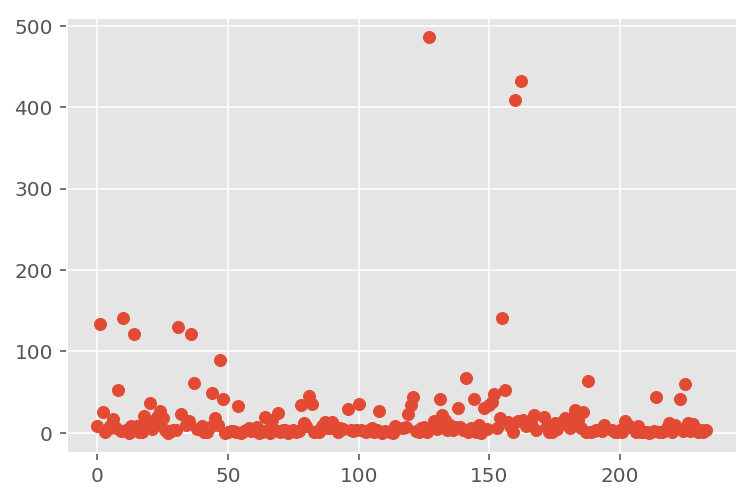

In [48]:
plt.scatter(id, RMSE/y)

## 残差プロット

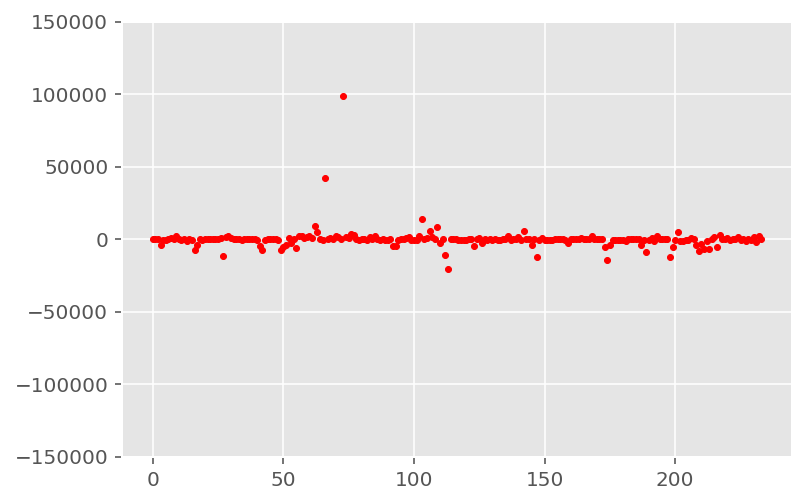

In [25]:
plt.ylim(-150000, 150000)
plt.scatter(id, e, c='red', marker='.')

## 理論値売上に対する誤差

In [26]:
sum(abs(e))/len(com_saleList)

2250.7235234466057

In [27]:
x = predictList*k

In [28]:
y = com_saleList

In [29]:
np.corrcoef(x,y)

array([[1.        , 0.94162417],
       [0.94162417, 1.        ]])

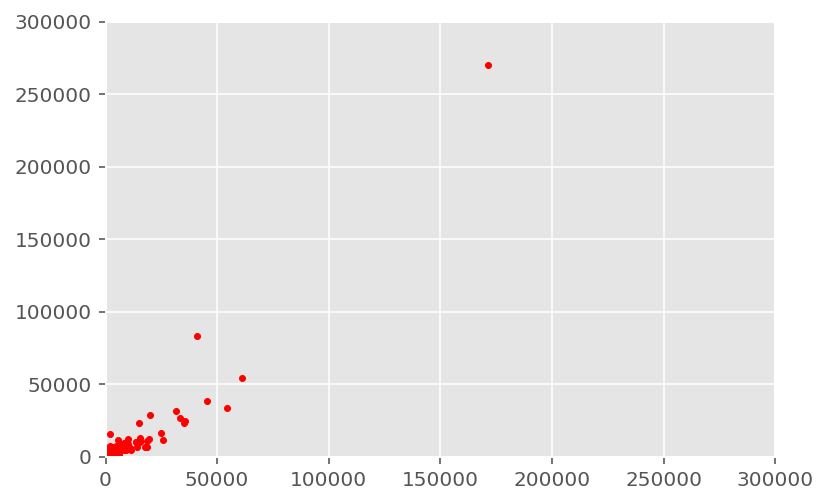

In [31]:
#理論値と予測値の散布図
plt.xlim(0, 300000)
plt.ylim(0, 300000)
plt.scatter(x, y, c='red', marker='.')

## 基本プロット

([array([223.,   6.,   3.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
           0.,   0.,   0.,   0.]),
  array([223.,   8.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   1.,   0.])],
 array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000., 180000., 200000., 220000., 240000., 260000.,
        280000., 300000.]),
 <a list of 2 Lists of Patches objects>)

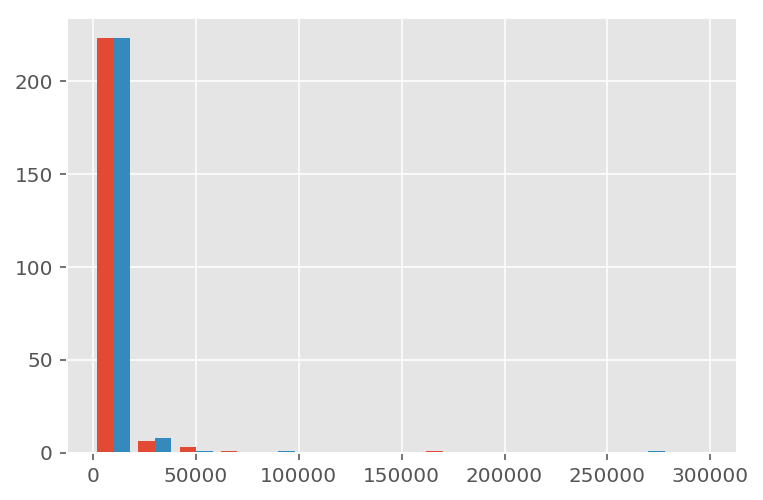

In [40]:
#predicted data(予測値)

plt.hist([x, y], stacked=False, range=(0, 300000), bins=15)

## 誤差のcsv出力

In [89]:
data1 = pd.DataFrame(id)
data2 = pd.DataFrame(com_name)
data3 = pd.DataFrame(e)
data = pd.concat([data1, data2, data3], axis=1)
#utf-8 でダメなら　shift-jis で
data.to_csv("data.csv", encoding = "utf-8")